# Session 06 Homework

The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column `'JAMB_Score'`).

In [1]:
# Necessary import
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

## Get Data
We will use the Students Performance in 2024 JAMB dataset from [Kaggle](https://www.kaggle.com/datasets/idowuadamo/students-performance-in-2024-jamb).

In [2]:
# Data url
perf_data = "https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv"

In [3]:
# Download the data
!wget $perf_data

--2024-11-03 17:26:25--  https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv [following]
--2024-11-03 17:26:40--  https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391501 (382K) [text/plain]
Saving to: ‘jamb_exam_results.csv’

jamb_exam_results.c 100%[===================>] 382.33K   879KB/s    in 0.4s    

2024-11-03 17:26:41 (879 KB/s) - ‘jamb_exam_results

In [4]:
# Files first rows
!head jamb_exam_results.csv

JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,None,1
182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1
202,25,85,2,13.6,Public,Urban,Yes,No,Medium,Low,6,15,Male,Low,Tertiary,1
251,35,85,4,2.6,Public,Urban,No,Yes,Low,Medium,7,16,Female,Medium,Primary,4
129,27,75,3,9.4,Public,Urban,No,Yes,Low,Medium,8,19,Female,Low,Tertiary,3
220,23,85,3,4.6,Public,Rural,No,No,Low,Medium,9,19,Female,Medium,Tertiary,1


Let's read the data:

In [5]:
# Read the dataframe
df = pd.read_csv("jamb_exam_results.csv")

# Last row
df.tail(1)

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
4999,218,34,100,1,7.0,Public,Urban,Yes,Yes,Medium,Medium,5000,16,Female,High,NaN,2


We could simply have read the url address:

In [6]:
# Read the dataframe
df = pd.read_csv(perf_data)

# Three first Rows
df.head(3)

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2


## Data Preparation

First, let's normalize columns' names:

In [7]:
# Standardize columns'names
df.columns = df.columns.str.lower().str.replace(" ", "_")

Our preparation steps are the following ones:

* Remove the `student_id` column.
* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution, using the `train_test_split` function and setting the `random_state` parameter to 1.
* Use `DictVectorizer(sparse = True)` to turn the dataframes into matrices.

In [8]:
# Drop the `student_id` column
df.drop(columns = "student_id", inplace = True)

In [9]:
# Filling missing values with zeros
df.fillna(value = 0, inplace = True)

In [10]:
# Check missing values
df.isnull().sum()

jamb_score                      0
study_hours_per_week            0
attendance_rate                 0
teacher_quality                 0
distance_to_school              0
school_type                     0
school_location                 0
extra_tutorials                 0
access_to_learning_materials    0
parent_involvement              0
it_knowledge                    0
age                             0
gender                          0
socioeconomic_status            0
parent_education_level          0
assignments_completed           0
dtype: int64

There are no more missing values, and the comlumn `student_id` has been deleted.

In [11]:
# Splitting into full train and test
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)

# Splitting into train and test
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [12]:
# Check datasets sizes after splitting
len(df_train), len(df_val), len(df_test)

(3000, 1000, 1000)

We can see that the splitting has been done well.

In [13]:
# Reset indexes
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

Let's extract the target variable `jamb_score` from our datasets:

In [14]:
# Get the target values
y_train = df_train.jamb_score.values
y_test = df_test.jamb_score.values
y_val = df_val.jamb_score.values

# Drop `jamb_score` from our feature datasets
del df_train["jamb_score"]
del df_test["jamb_score"]
del df_val["jamb_score"]

We can now turn our feature dataframes into matrices:

In [15]:
# Convert data to list of dictionaries
train_dicts = df_train.to_dict(orient = 'records')

# Initialize One-Hot-Encoder
One_Hot_Enc = DictVectorizer(sparse = True)
# One-Hot-Encoder training and train data encoding
X_train = One_Hot_Enc.fit_transform(train_dicts)

In [16]:
# Convert data to list of dictionaries
val_dicts = df_val.to_dict(orient = 'records')

# Validation data One-Hot-Encoding
X_val = One_Hot_Enc.transform(val_dicts)

In [17]:
# Convert data to list of dictionaries
test_dicts = df_test.to_dict(orient = 'records')

# Validation data One-Hot-Encoding
X_test = One_Hot_Enc.transform(test_dicts)

### Question 1

Let's train a decision tree regressor with `max_depth=1` to predict the `jamb_score` variable.

In [18]:
# Initialize decision tree regressor
dt_reg = DecisionTreeRegressor(max_depth = 1)
# Model training
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [19]:
# Visualize the decision tree model rules
print(export_text(dt_reg, feature_names = list(One_Hot_Enc.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



The feature used for splitting the data is `study_hours_per_week`.

### Question 2

Let's train a random forest model with the parameters: `n_estimators = 10`, `random_state = 1` and `n_jobs = -1` (optional - to make training faster).

In [20]:
# Initialize random forest regressor
rf_reg = RandomForestRegressor(n_estimators = 10, random_state = 1, n_jobs = -1)
# Model training
rf_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
# Make predictions
y_pred = rf_reg.predict(X_val)
# RMSE score
print("Random Forest RMSE score= %.3f." % root_mean_squared_error(y_val, y_pred))

Random Forest RMSE score= 42.137.


The RMSE of this model on validation is `42.13`.

### Question 3

Now let's experiment with the `n_estimators` parameter, trying different values of this parameter from 10 to 200 with step 10. We set `random_state` to `1` for reproducibility when evaluating the model on the validation dataset.

In [22]:
# Initialize scores
scores = []

# Possible number of estimators
n_params = np.arange(10, 201, 10)

# Random forest fine-tuning with number of trees
for n in n_params:
    # Initialize random forest regressor
    rf_reg = RandomForestRegressor(n_estimators = n, random_state = 1, n_jobs = -1)
    # Model training
    rf_reg.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_reg.predict(X_val)
    # RMSE score
    rmse = root_mean_squared_error(y_val, y_pred)

    # Store number of trees and corresponding score
    scores.append((n, rmse))

# Create a dataframe for scores
df_scores = pd.DataFrame(scores, columns = ['n_estimators', 'rmse'])
df_scores.sort_values(by = "rmse", ascending = True).head()

,n_estimators,rmse
8,90,40.504346
9,100,40.516805
7,80,40.539333
10,110,40.593353
13,140,40.594852


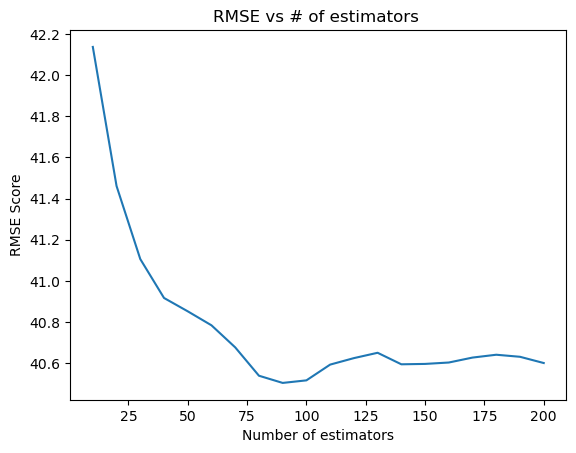

In [23]:
# Plot scores by estimators
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.xlabel("Number of estimators")
plt.ylabel("RMSE Score")
plt.title("RMSE vs # of estimators ")
plt.show()

RMSE score stops improving after the value of `80` for `n_estimators`.

### Question 4

Let's find the best `max_depth` between different values of `max_depth`: `[10, 15, 20, 25]`. For each of these values, we evaluate the mean RMSE with different values of `n_estimators` from 10 till 200 (with step 10), and fix the random seed: `random_state=1` for reproducibility.

In [24]:
# Initialize scores
scores = []

# Possible depths for trees
depth_params = [10, 15, 20, 25]

# Random forest fine-tuning with maximum depth
for d in depth_params:
    # Random forest fine-tuning with number of trees
    for n in n_params:
        # Initialize random forest regressor
        rf_reg = RandomForestRegressor(n_estimators = n,
                                       max_depth = d,
                                       random_state = 1,
                                       n_jobs = -1)
        # Model training
        rf_reg.fit(X_train, y_train)

        # Make predictions
        y_pred = rf_reg.predict(X_val)
        # RMSE score
        rmse = root_mean_squared_error(y_val, y_pred)

        # Store hyperparameters and corresponding score
        scores.append((d, n, rmse))

# Columns names
columns = ['max_depth', 'n_estimators', 'rmse']
# Create a dataframe for scores
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.sort_values(by = "rmse", ascending = True).head()

,max_depth,n_estimators,rmse
8,10,90,40.173900
7,10,80,40.210305
9,10,100,40.250490
3,10,40,40.270069
5,10,60,40.277035


In [25]:
# Let's get the rounded mean RMSE for each depth
df_scores.groupby("max_depth")["rmse"].mean().round(3)

max_depth
10    40.392
15    40.735
20    40.740
25    40.788
Name: rmse, dtype: float64

The best `max_depth`, using the mean RMSE is `10`.

### Question 5

We can extract feature importance information from tree-based models. At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models. In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

Let's find the most important feature, when training a random forest model with the parameters: `n_estimators = 10`, `max_depth = 20`, `random_state = 1`, `n_jobs = -1`.

In [26]:
# Initialize random forest regressor
rf_reg = RandomForestRegressor(n_estimators = 10,
                               max_depth = 20,
                               random_state = 1,
                               n_jobs = -1)
# Model training
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [27]:
# Get feature importance
feat_imp = pd.Series(data = rf_reg.feature_importances_, index = list(One_Hot_Enc.get_feature_names_out()))
# Sort feature importance
feat_imp.sort_values(ascending = False).head()

study_hours_per_week    0.248354
attendance_rate         0.149729
distance_to_school      0.136486
teacher_quality         0.082682
age                     0.069311
dtype: float64

The most important feature among `study_hours_per_week`, `attendance_rate`, `distance_to_school` and `teacher_quality` is `study_hours_per_week`.


### Question 6

Now let's train an XGBoost model! We will tune the `eta` parameter. First, we show how to install `XGBoost`.

In [28]:
# install xgboost library
!pip install xgboost

Then, we will create DMatrix for train and validation, and a watchlist to traceback scores during model training. 

In [30]:
# Wrap the training data into an optimized structure
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names =  list(One_Hot_Enc.get_feature_names_out()))
# Wrap the validation data into an optimized structure
dval = xgb.DMatrix(X_val, label = y_val, feature_names =  list(One_Hot_Enc.get_feature_names_out()))

# Dataset on which we want to iterate our model
watchlist = [(dtrain, 'train'), (dval, 'val')]

The model will be trained for 100 rounds with these parameters :

```python

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
```

In [31]:
# XGBoost Model hyperparameters 
xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 6, # maximum depth for trees
    'min_child_weight': 1, # minimum number of samples per child nodes
    'objective': 'reg:squarederror', # regression
    'nthread': 8, # for parallelized training
    'seed': 1, # for reproducibility
    'verbosity': 1 # to show warnings if any during model traning
}

# Train model and store it
model = xgb.train(xgb_params, dtrain, num_boost_round = 100)

# Make predictions
y_pred = model.predict(dval)

# RMSE score
print("XGBoost RMSE score= %.5f." % root_mean_squared_error(y_val, y_pred))

XGBoost RMSE score= 43.41882.


We finally change `eta` value from `0.3` to `0.1`.

In [32]:
# XGBoost Model hyperparameters 
xgb_params = {
    'eta': 0.1, # learning rate
    'max_depth': 6, # maximum depth for trees
    'min_child_weight': 1, # minimum number of samples per child nodes
    'objective': 'reg:squarederror', # binary classification
    'nthread': 8, # for parallelized training
    'seed': 1, # for reproducibility
    'verbosity': 1 # to show warnings if any during model traning
}

# Train model and store it
model = xgb.train(xgb_params, dtrain, num_boost_round = 100)

# RMSE score
print("XGBoost RMSE score= %.5f." % root_mean_squared_error(y_val, y_pred))

XGBoost RMSE score= 43.41882.


`Both eta` lead to the same RMSE score on the validation dataset.

---